In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [3]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
EXPECTED_N = 10000

In [19]:
def simulator(z):
    return np.array([z[0]])

def noise(x, z = None, noise=0.01):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.55,0.45])
zdim = len(z0)
x0 = simulator(z0)  # Using Asimov data

In [20]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [21]:
intensity = None

for _ in range(4):
    if intensity is None:
        intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N, dim=zdim)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
            factor_mask=intensity.factor_mask,
        )
    cache.grow(intensity)
    cache.simulate(simulator)
    points = swyft.Points(cache, intensity, noise)
    re = swyft.RatioEstimator(x0, points, device=DEVICE)
    re.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Simulate:   3%|▎         | 260/9879 [00:00<00:03, 2591.80it/s]

Adding 9879 new samples. Run simulator!


Simulate: 100%|██████████| 9879/9879 [00:02<00:00, 3406.37it/s]


Initializing network...
yshape (shape of features between head and legs): 1
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 51.219619035720825
Validation loss: 51.358163833618164
Total epochs: 2
LR iteration 1
Validation loss: 50.790682554244995
Validation loss: 50.96031332015991
Total epochs: 2
LR iteration 2
Validation loss: 50.91681146621704
Validation loss: 50.399630546569824
Validation loss: 50.892493724823
Total epochs: 3


Simulate:   4%|▍         | 357/8874 [00:00<00:02, 3564.63it/s]

Constrained posterior area: 0.10935603
Adding 8874 new samples. Run simulator!


Simulate: 100%|██████████| 8874/8874 [00:02<00:00, 3482.91it/s]


Initializing network...
yshape (shape of features between head and legs): 1
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 83.54758167266846
Validation loss: 74.73989868164062
Validation loss: 73.6243736743927
Validation loss: 72.32104444503784
Validation loss: 70.56003642082214
Validation loss: 71.882408618927
Total epochs: 6
LR iteration 1
Validation loss: 70.83314275741577
Validation loss: 70.58118939399719
Validation loss: 69.9083182811737
Validation loss: 70.342041015625
Total epochs: 4
LR iteration 2
Validation loss: 70.88902401924133
Validation loss: 70.60294437408447
Validation loss: 70.65607738494873
Total epochs: 3


Simulate: 100%|██████████| 2/2 [00:00<00:00, 1690.23it/s]

Constrained posterior area: 0.10931829
Adding 2 new samples. Run simulator!
Initializing network...
yshape (shape of features between head and legs): 1
Start training
No new simulator runs required.


LR iteration 0
Validation loss: 77.68200445175171
Validation loss: 75.38076829910278
Validation loss: 74.99932765960693
Validation loss: 73.78721237182617
Validation loss: 73.47853708267212
Validation loss: 73.22378540039062
Validation loss: 74.04142951965332
Total epochs: 7
LR iteration 1
Validation loss: 71.7378363609314
Validation loss: 73.41283369064331
Total epochs: 2
LR iteration 2
Validation loss: 74.81049108505249
Validation loss: 72.39901304244995
Validation loss: 72.23955535888672
Validation loss: 73.48638772964478
Total epochs: 4


Simulate: 100%|██████████| 504/504 [00:00<00:00, 3513.35it/s]

Constrained posterior area: 0.10351211
Adding 504 new samples. Run simulator!


Initializing network...
yshape (shape of features between head and legs): 1
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 74.41467475891113
Validation loss: 72.52661752700806
Validation loss: 72.55184841156006
Total epochs: 3
LR iteration 1
Validation loss: 70.20968222618103
Validation loss: 71.98707151412964
Total epochs: 2
LR iteration 2
Validation loss: 71.61253643035889
Validation loss: 70.34820294380188
Validation loss: 71.1629433631897
Total epochs: 3


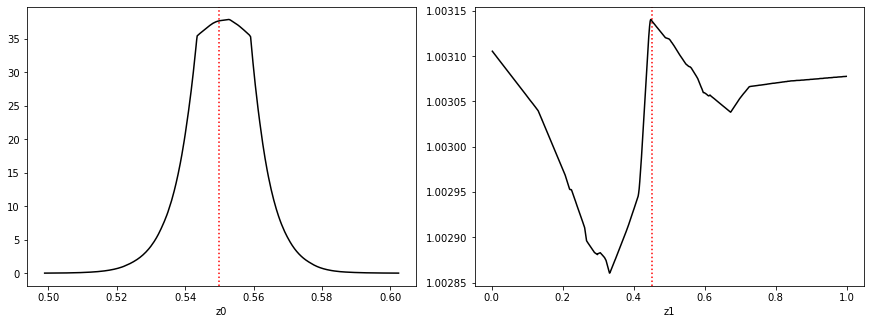

In [22]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys')

In [47]:
re2 = swyft.RatioEstimator(x0, points, combinations = [[0, 1]], device=DEVICE)

In [48]:
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Initializing network...
yshape (shape of features between head and legs): 1
Start training
LR iteration 0
Validation loss: 9.356301993131638
Validation loss: 8.709925025701523
Validation loss: 6.607302263379097
Validation loss: 5.968762546777725
Validation loss: 4.795531056821346
Validation loss: 4.422317683696747
Validation loss: 7.411180155351758
Total epochs: 7
LR iteration 1
Validation loss: 4.1008042357862
Validation loss: 4.239965181797743
Total epochs: 2
LR iteration 2
Validation loss: 3.691053457558155
Validation loss: 3.9878901839256287
Total epochs: 2
